In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud

In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

In [58]:
df = pd.read_csv("Predict Hair Fall.csv")

In [59]:
df.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [60]:
print(df.shape)

(999, 13)


In [61]:
df.nunique()

Id                           995
Genetics                       2
Hormonal Changes               2
Medical Conditions            11
Medications & Treatments      11
Nutritional Deficiencies      11
Stress                         3
Age                           33
Poor Hair Care Habits          2
Environmental Factors          2
Smoking                        2
Weight Loss                    2
Hair Loss                      2
dtype: int64

In [62]:
df.isnull().sum()

Id                           0
Genetics                     0
Hormonal Changes             0
Medical Conditions           0
Medications & Treatments     0
Nutritional Deficiencies     0
Stress                       0
Age                          0
Poor Hair Care Habits        0
Environmental Factors        0
Smoking                      0
Weight Loss                  0
Hair Loss                    0
dtype: int64

In [63]:
df.duplicated().sum()

0

In [64]:
df.dtypes

Id                            int64
Genetics                     object
Hormonal Changes             object
Medical Conditions           object
Medications & Treatments     object
Nutritional Deficiencies     object
Stress                       object
Age                           int64
Poor Hair Care Habits        object
Environmental Factors        object
Smoking                      object
Weight Loss                  object
Hair Loss                     int64
dtype: object

In [65]:
# Remove rows where any column has 'No Data'
df = df.replace("No Data", np.nan).dropna()
df.shape

(809, 13)

In [66]:
numerical_columns=df.select_dtypes(include=['int64']).columns
categorical_columns=df.select_dtypes(include=['object']).columns

In [67]:
numerical_columns

Index(['Id', 'Age', 'Hair Loss'], dtype='object')

In [68]:
categorical_columns

Index(['Genetics', 'Hormonal Changes', 'Medical Conditions',
       'Medications & Treatments', 'Nutritional Deficiencies ', 'Stress',
       'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss '],
      dtype='object')

In [69]:
print(df.columns)
df.columns = df.columns.str.strip()

Index(['Id', 'Genetics', 'Hormonal Changes', 'Medical Conditions',
       'Medications & Treatments', 'Nutritional Deficiencies ', 'Stress',
       'Age', 'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss ', 'Hair Loss'],
      dtype='object')


In [70]:
# Function to display unique categories for each variable
def identify_categories(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Variable: {column}")
        print(f"Categories: {unique_values}")
        print("="*30)

identify_categories(df)

Variable: Id
Categories: [148393 155074 118261 111915 139661 112032 140785 187999 118858 159158
 156086 178256 150154 130552 116190 194441 147404 136709 187362 148974
 116818 142062 147833 190967 114579 159949 133091 157912 144334 136948
 177638 158783 132733 178632 173043 112613 111169 125738 187509 154811
 147982 137086 141739 121914 147047 122584 123906 138992 110488 113790
 172772 110727 168306 174267 196819 143895 178213 180864 178939 194055
 176759 192870 199428 138548 166682 189612 176953 173202 114166 185347
 164602 196847 190313 195235 118325 150587 199900 142431 120699 187633
 125204 168967 147074 179153 118171 139016 151443 154980 114564 155613
 176266 169244 149266 129605 140772 172639 116356 119044 194617 116483
 125476 191118 150786 169462 176009 152804 188581 127051 149333 142915
 191636 145250 116875 121433 187558 158241 193610 135928 189411 136501
 135858 120402 189702 144618 193188 117715 177809 136782 166564 150038
 131576 184677 139985 197827 181286 160629 126430 11

In [71]:
df.describe()

,Id,Age,Hair Loss
count,809.000000,809.000000,809.000000
mean,153247.406675,34.758962,0.504326
std,25498.910817,8.361717,0.500291
min,110003.000000,18.000000,0.000000
25%,131739.000000,28.000000,0.000000
50%,152667.000000,35.000000,1.000000
75%,175168.000000,42.000000,1.000000
max,199949.000000,50.000000,1.000000


In [72]:
# Function to identify outliers in numerical columns
def identify_numerical_outliers(df, numerical_columns, contamination=0.05, random_state=42):
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    outliers = iso_forest.fit_predict(df[numerical_columns])
    
    # Mark numerical outliers as True where outliers == -1
    df['numerical_outlier'] = (outliers == -1)
    
    return df

# Function to identify outliers in categorical columns based on frequency threshold
def identify_categorical_outliers(df, categorical_columns, threshold=0.01):
    outlier_flags = pd.DataFrame(index=df.index)
    
    for col in categorical_columns:
        freq = df[col].value_counts(normalize=True)
        rare_values = freq[freq < threshold].index
        
        # Mark categorical outliers as True if the value is in the rare list
        outlier_flags[f'{col}_outlier'] = df[col].isin(rare_values)
    
    # Combine all categorical outliers into a single column
    df['categorical_outlier'] = outlier_flags.any(axis=1)
    
    return df


# Identify numerical and categorical columns in the dataset
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical outliers
df = identify_numerical_outliers(df, numerical_columns)

# Identify categorical outliers (e.g., less than 1% frequency)
df = identify_categorical_outliers(df, categorical_columns, threshold=0.01)

# Print results
numerical_outlier_percentage = (df['numerical_outlier'].sum() / len(df)) * 100
categorical_outlier_percentage = (df['categorical_outlier'].sum() / len(df)) * 100

print(f"Percentage of numerical outliers: {numerical_outlier_percentage:.2f}%")
print(f"Percentage of categorical outliers: {categorical_outlier_percentage:.2f}%")


Percentage of numerical outliers: 5.07%
Percentage of categorical outliers: 0.00%


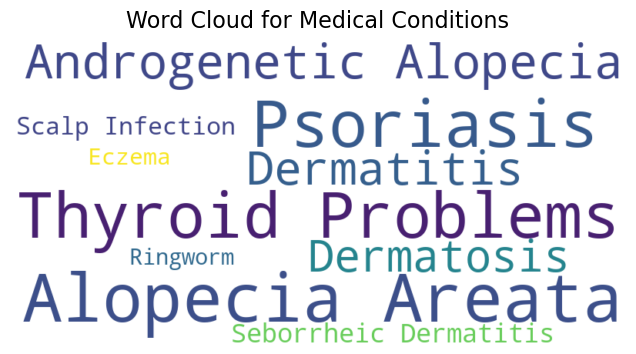

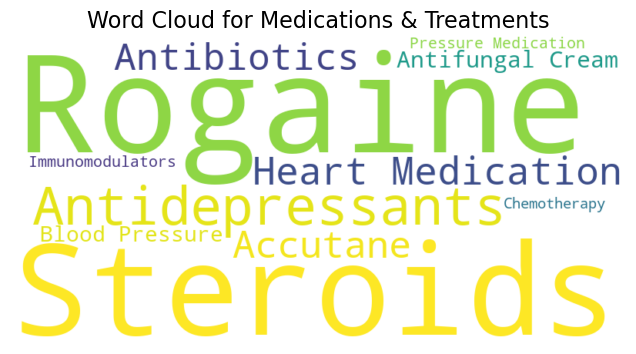

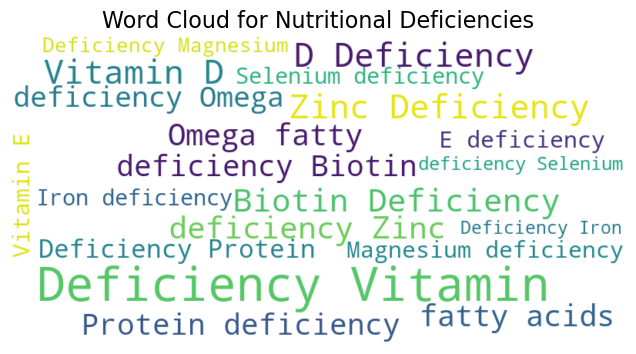

In [73]:
def generate_wordcloud(column_data, title):
    text_data = ' '.join(column_data.astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes for better visualization
    plt.title(title, fontsize=16)
    plt.show()

# Generate word clouds for each of the three variables
generate_wordcloud(df['Medical Conditions'], 'Word Cloud for Medical Conditions')
generate_wordcloud(df['Medications & Treatments'], 'Word Cloud for Medications & Treatments')
generate_wordcloud(df['Nutritional Deficiencies'], 'Word Cloud for Nutritional Deficiencies')


### Basic Data Preprocessing

In [74]:
X = df.drop(['Hair Loss'], axis =1 )
y = df['Hair Loss']

categorical_cols = X.select_dtypes('O').columns.tolist()
numerical_cols = X.select_dtypes(exclude = 'O').columns.tolist()

In [75]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", oh_transformer, categorical_cols),
        ("StandardScaler", numeric_transformer, numerical_cols),
    ]
)

In [76]:
X_scaled = preprocessor.fit_transform(X)
X_scaled

<809x49 sparse matrix of type '<class 'numpy.float64'>'
	with 10517 stored elements in Compressed Sparse Row format>

**NOTE:** Based on the domain (healthcare), the dataset's outliers and extreme Numerical feature values are equally important to normal data for Hair Loss Classification. That's why, the outliers are not eliminated and the data are kept consistent with the original dataset.


In [77]:

binary_columns = ['Genetics', 'Hormonal Changes', 'Poor Hair Care Habits', 
                  'Environmental Factors', 'Smoking', 'Weight Loss']

df[binary_columns] = df[binary_columns].applymap(lambda x: 1 if x == 'Yes' else 0)

# Ordinal encoding for Stress (1 for Low, 2 for Moderate, 3 for High)
df['Stress'] = df['Stress'].map({'Low': 1, 'Moderate': 2, 'High': 3})

# Apply categorical encoding (1, 2, 3, ...) for Medical Conditions, Medications & Treatments, and Nutritional Deficiencies
df["Medical Conditions"] = df["Medical Conditions"].map({'Eczema':1, 'Dermatosis':2, 'Ringworm':3, 'Psoriasis':4, 'Alopecia Areata':5,
                                                         'Scalp Infection':6, 'Seborrheic Dermatitis':7, 'Dermatitis':8, 'Thyroid Problems':9,
                                                         'Androgenetic Alopecia':10})
df["Medications & Treatments"] = df["Medications & Treatments"].map({ 'Antibiotics':1, 'Antifungal Cream':2, 'Accutane':3, 'Chemotherapy':4,
                                                                     'Steroids':5, 'Rogaine':6, 'Blood Pressure Medication':7, 'Immunomodulators':8,
                                                                     'Antidepressants ':9, 'Heart Medication ':10})
df["Nutritional Deficiencies"] = df["Nutritional Deficiencies"].map({'Magnesium deficiency':1, 'Protein deficiency':2, 'Biotin Deficiency ':3,
                                                                     'Iron deficiency':4, 'Selenium deficiency':5, 'Omega-3 fatty acids':6,'Zinc Deficiency':7, 
                                                                     'Vitamin A Deficiency':8, 'Vitamin D Deficiency':9, 'Vitamin E deficiency':10})

In [78]:
df = df.drop(['numerical_outlier', 'categorical_outlier','Id'], axis=1)
df.head()

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
1,0,0,1.0,1,1,3,43,1,1,0,0,0
2,0,0,2.0,2,2,2,26,1,1,0,1,0
3,1,1,3.0,1,3,2,46,1,1,0,0,0
4,0,0,4.0,3,4,2,30,0,1,1,0,1
5,1,0,4.0,1,1,1,37,0,1,0,1,1


In [79]:
df.nunique()

Genetics                     2
Hormonal Changes             2
Medical Conditions           9
Medications & Treatments    10
Nutritional Deficiencies    10
Stress                       3
Age                         30
Poor Hair Care Habits        2
Environmental Factors        2
Smoking                      2
Weight Loss                  2
Hair Loss                    2
dtype: int64

In [80]:
df.isna().sum()

Genetics                     0
Hormonal Changes             0
Medical Conditions          98
Medications & Treatments     0
Nutritional Deficiencies     0
Stress                       0
Age                          0
Poor Hair Care Habits        0
Environmental Factors        0
Smoking                      0
Weight Loss                  0
Hair Loss                    0
dtype: int64

In [81]:
df['Medical Conditions'] = df['Medical Conditions'].fillna(df['Medical Conditions'].mode().iloc[0])

In [83]:
df.isna().sum()

Genetics                    0
Hormonal Changes            0
Medical Conditions          0
Medications & Treatments    0
Nutritional Deficiencies    0
Stress                      0
Age                         0
Poor Hair Care Habits       0
Environmental Factors       0
Smoking                     0
Weight Loss                 0
Hair Loss                   0
dtype: int64

## Models

In [84]:
from sklearn.model_selection import train_test_split

X = df.drop(['Hair Loss'], axis =1 )
y = df['Hair Loss']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [85]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import xgboost as xgb

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Define models
models = {
    'Multiple Logistic': LogisticRegression(),
    'Ridge': LogisticRegression(penalty='l2', C=1.0),
    'Lasso': LogisticRegression(penalty='l1', solver='liblinear', C=1),
    'Elastic-net': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', C=1),
    'Random Forest': RandomForestClassifier(),
    #'GaussianNB': GaussianNB(),
    'SVC': SVC(probability=True),
}

# Loop through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Training set predictions
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_cm = confusion_matrix(y_train, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0])
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])

    # Test set predictions
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_cm = confusion_matrix(y_test, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])

    # Print results
    print(name)
    print('=' * len(name))
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Training Sensitivity: {train_sensitivity:.4f}')
    print(f'Training Specificity: {train_specificity:.4f}')
    
    print('\n')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Confusion Matrix:\n{test_cm}')
    print(f'Test Sensitivity: {test_sensitivity:.4f}')
    print(f'Test Specificity: {test_specificity:.4f}')
    print('\n\n')


Multiple Logistic
Training Accuracy: 0.5564
Training Error Rate: 0.4436
Training F1 Score: 0.5528
Training Confusion Matrix:
[[146 168]
 [119 214]]
Training Sensitivity: 0.6426
Training Specificity: 0.4650


Test Accuracy: 0.4444
Test Error Rate: 0.5556
Test F1 Score: 0.4410
Test Confusion Matrix:
[[32 55]
 [35 40]]
Test Sensitivity: 0.5333
Test Specificity: 0.3678



Ridge
=====
Training Accuracy: 0.5564
Training Error Rate: 0.4436
Training F1 Score: 0.5528
Training Confusion Matrix:
[[146 168]
 [119 214]]
Training Sensitivity: 0.6426
Training Specificity: 0.4650


Test Accuracy: 0.4444
Test Error Rate: 0.5556
Test F1 Score: 0.4410
Test Confusion Matrix:
[[32 55]
 [35 40]]
Test Sensitivity: 0.5333
Test Specificity: 0.3678



Lasso
=====
Training Accuracy: 0.5626
Training Error Rate: 0.4374
Training F1 Score: 0.5593
Training Confusion Matrix:
[[149 165]
 [118 215]]
Training Sensitivity: 0.6456
Training Specificity: 0.4745


Test Accuracy: 0.4383
Test Error Rate: 0.5617
Test F1 Score: 0

## Parameter Tunning

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, f1_score, fbeta_score
import warnings
warnings.filterwarnings('ignore')

# Define models and their respective parameter grids, including Decision Tree and KNN
models = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Extra Trees': (ExtraTreesClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    #'SVC': (SVC(probability=True), {
    #    'C': [0.1, 1, 10],
    #    'kernel': ['linear', 'rbf'],
    #    'gamma': ['scale', 'auto']
    #}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9]
    }),
    'CatBoost': (CatBoostClassifier(verbose=0), {
        'iterations': [100, 200, 300],
        'depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9]
    }),
    'AdaBoost': (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1.0]
    })
}

# Loop through models, perform hyperparameter tuning, and evaluate performance
for name, (model, param_grid) in models.items():
    print(f"\n{name}")
    print("=" * len(name))
    
    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Training predictions
    train_pred = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_prec = precision_score(y_train, train_pred, average='weighted')
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_f2 = fbeta_score(y_train, train_pred, beta=2, average='weighted')
    train_cm = confusion_matrix(y_train, train_pred)
    
    # Test predictions
    test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_prec = precision_score(y_test, test_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_f2 = fbeta_score(y_test, test_pred, beta=2, average='weighted')
    test_cm = confusion_matrix(y_test, test_pred)
    
    # Print results
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    
    print("\nTraining Performance")
    print(f"Accuracy: {train_acc:.4f}")
    print(f"Precision: {train_prec:.4f}")
    print(f"F1 Score: {train_f1:.4f}")
    print(f"F2 Score: {train_f2:.4f}")
    print(f"Confusion Matrix:\n{train_cm}")
    
    print("\nTest Performance")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"F2 Score: {test_f2:.4f}")
    print(f"Confusion Matrix:\n{test_cm}")
    print("\n" + "=" * len(name))



Logistic Regression
Best Hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}

Training Performance
Accuracy: 0.5533
Precision: 0.5542
F1 Score: 0.5414
F2 Score: 0.5458
Confusion Matrix:
[[122 192]
 [ 97 236]]

Test Performance
Accuracy: 0.4321
Precision: 0.4378
F1 Score: 0.4102
F2 Score: 0.4178
Confusion Matrix:
[[22 65]
 [27 48]]


Random Forest
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Training Performance
Accuracy: 0.9907
Precision: 0.9908
F1 Score: 0.9907
F2 Score: 0.9907
Confusion Matrix:
[[309   5]
 [  1 332]]

Test Performance
Accuracy: 0.5000
Precision: 0.5079
F1 Score: 0.4984
F2 Score: 0.4980
Confusion Matrix:
[[38 49]
 [32 43]]


Extra Trees
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Training Performance
Accuracy: 0.9938
Precision: 0.9939
F1 Score: 0.9938
F2 Score: 0.9938
Confusion Matrix:
[[310   4]
 [  0 333]

In [88]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure the training and testing labels are numpy arrays
y_train_adjusted = np.array(y_train)
y_test_adjusted = np.array(y_test)

# Define the parameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation for Decision Tree
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), 
                           param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train_adjusted)

# Get the best model from the grid search
best_dt_model = grid_search.best_estimator_

# Make predictions on the train set
y_pred_train = best_dt_model.predict(X_train)

# Make predictions on the test set
y_pred_test = best_dt_model.predict(X_test)

# Evaluate the performance on the train set
train_accuracy = accuracy_score(y_train_adjusted, y_pred_train)
train_conf_matrix = confusion_matrix(y_train_adjusted, y_pred_train)

# Evaluate the performance on the test set
test_accuracy = accuracy_score(y_test_adjusted, y_pred_test)
test_conf_matrix = confusion_matrix(y_test_adjusted, y_pred_test)
classification_report_result = classification_report(y_test_adjusted, y_pred_test)

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report_result)

print("\nConfusion Matrix (Train Set):")
print(train_conf_matrix)

print("\nConfusion Matrix (Test Set):")
print(test_conf_matrix)

Train Accuracy: 0.8779
Test Accuracy: 0.5247

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.57      0.47      0.52        87
           1       0.49      0.59      0.53        75

    accuracy                           0.52       162
   macro avg       0.53      0.53      0.52       162
weighted avg       0.53      0.52      0.52       162


Confusion Matrix (Train Set):
[[283  31]
 [ 48 285]]

Confusion Matrix (Test Set):
[[41 46]
 [31 44]]


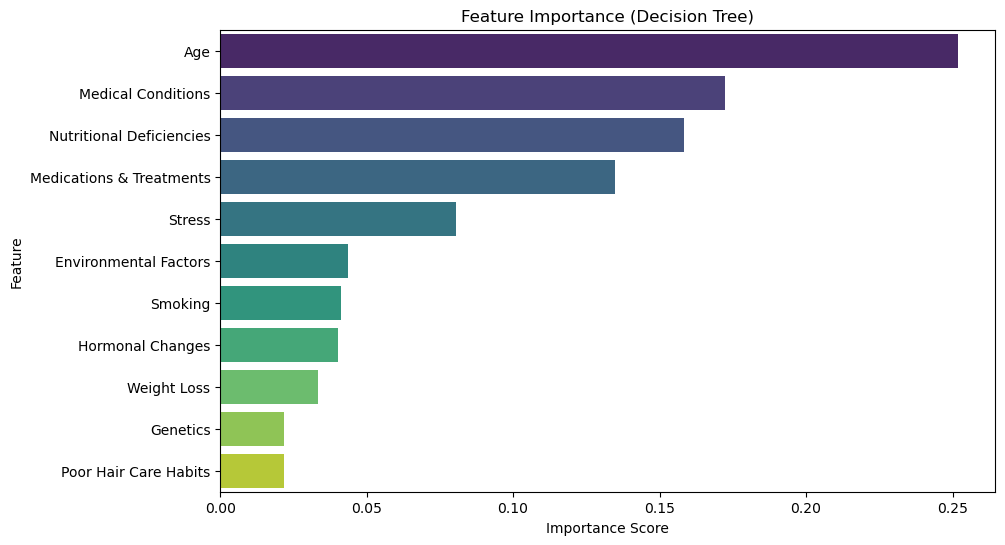

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importance from the best decision tree model
feature_importance = best_dt_model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


## Decision Tree

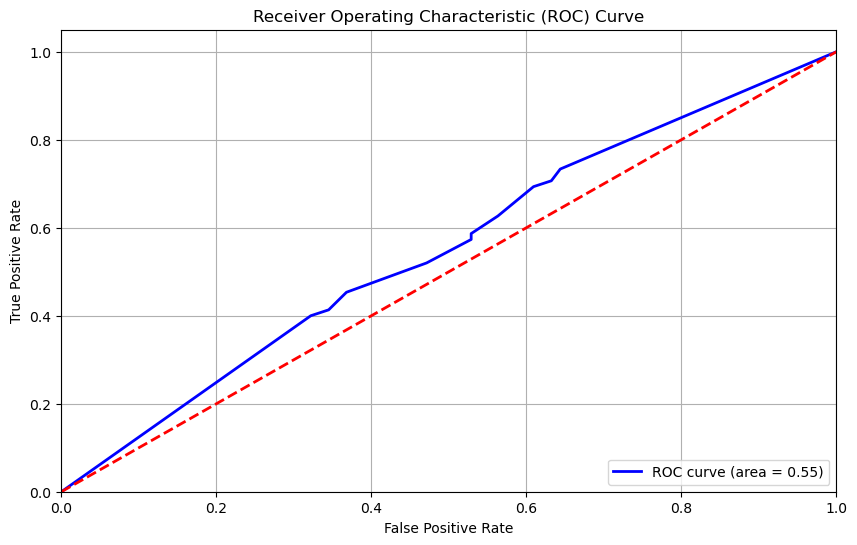

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_pred_proba = best_dt_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_adjusted, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define a threshold for feature importance (based on Decision Tree's feature_importances_)
threshold = 0.01

# Select only features where the importance value is greater than the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].values

# Check if any important features are selected
if len(important_features) == 0:
    raise ValueError("No important features were selected. Adjust the threshold.")

# Filter the training and test datasets to include only the important features
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# Refit the Decision Tree model using only the important features
best_dt_model_important = DecisionTreeClassifier(max_depth=20, min_samples_split=5, min_samples_leaf=2)  # You can fine-tune these parameters or use grid search
best_dt_model_important.fit(X_train_important, y_train_adjusted)

# Make predictions on the train and test sets using the model with important features
y_pred_train_important = best_dt_model_important.predict(X_train_important)
y_pred_test_important = best_dt_model_important.predict(X_test_important)

# Evaluate the performance of the model
train_accuracy_important = accuracy_score(y_train_adjusted, y_pred_train_important)
test_accuracy_important = accuracy_score(y_test_adjusted, y_pred_test_important)

train_conf_matrix_important = confusion_matrix(y_train_adjusted, y_pred_train_important)
test_conf_matrix_important = confusion_matrix(y_test_adjusted, y_pred_test_important)

classification_report_important = classification_report(y_test_adjusted, y_pred_test_important)

# Print results
print(f"Train Accuracy (Important Features): {train_accuracy_important:.4f}")
print(f"Test Accuracy (Important Features): {test_accuracy_important:.4f}")
print("\nClassification Report (Test Set, Important Features):")
print(classification_report_important)

print("\nConfusion Matrix (Train Set, Important Features):")
print(train_conf_matrix_important)

print("\nConfusion Matrix (Test Set, Important Features):")
print(test_conf_matrix_important)


Train Accuracy (Important Features): 0.8903
Test Accuracy (Important Features): 0.5247

Classification Report (Test Set, Important Features):
              precision    recall  f1-score   support

           0       0.57      0.49      0.53        87
           1       0.49      0.56      0.52        75

    accuracy                           0.52       162
   macro avg       0.53      0.53      0.52       162
weighted avg       0.53      0.52      0.52       162


Confusion Matrix (Train Set, Important Features):
[[300  14]
 [ 57 276]]

Confusion Matrix (Test Set, Important Features):
[[43 44]
 [33 42]]


In [92]:
### Create a Pickle file using seralization
import pickle
pickle_out = open("best_dt_model.pkl","wb")
pickle.dump(best_dt_model,pickle_out)
pickle_out.close()

## XG Boost

In [93]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

y_train_adjusted = np.array(y_train)
y_test_adjusted = np.array(y_test)

# Define the XGBoost classifier
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=3)  # Specify number of classes

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train_adjusted)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the train set
y_pred_train = best_xgb_model.predict(X_train)

# Make predictions on the test set
y_pred_test = best_xgb_model.predict(X_test)

# Evaluate the performance on the train set
train_accuracy = accuracy_score(y_train_adjusted, y_pred_train)
train_conf_matrix = confusion_matrix(y_train_adjusted, y_pred_train)

# Evaluate the performance on the test set
test_accuracy = accuracy_score(y_test_adjusted, y_pred_test)
test_conf_matrix = confusion_matrix(y_test_adjusted, y_pred_test)
classification_report_result = classification_report(y_test_adjusted, y_pred_test)

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report_result)

print("\nConfusion Matrix (Train Set):")
print(train_conf_matrix)

print("\nConfusion Matrix (Test Set):")
print(test_conf_matrix)


Train Accuracy: 0.8810
Test Accuracy: 0.4691

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.51      0.39      0.44        87
           1       0.44      0.56      0.49        75

    accuracy                           0.47       162
   macro avg       0.47      0.48      0.47       162
weighted avg       0.48      0.47      0.47       162


Confusion Matrix (Train Set):
[[261  53]
 [ 24 309]]

Confusion Matrix (Test Set):
[[34 53]
 [33 42]]


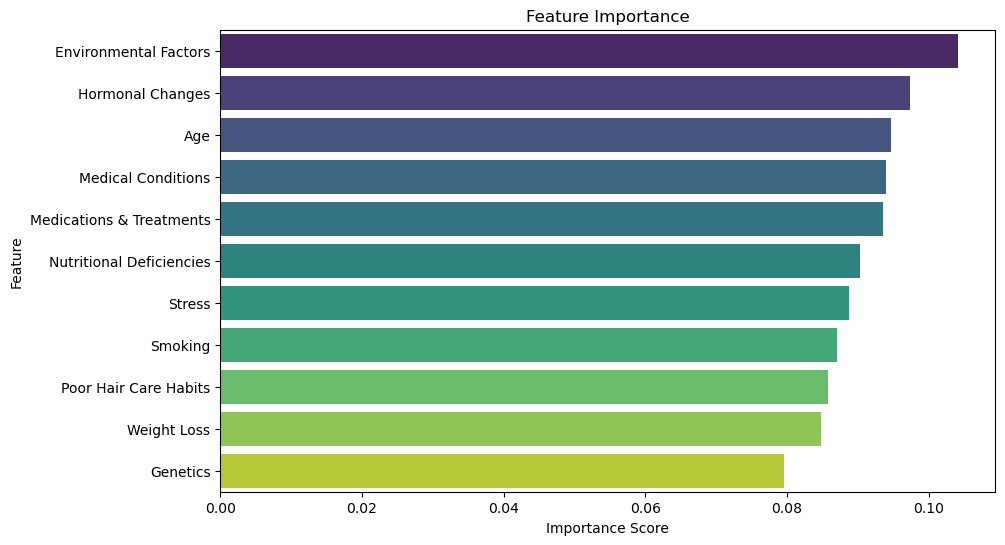

In [94]:
# Get feature importance
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

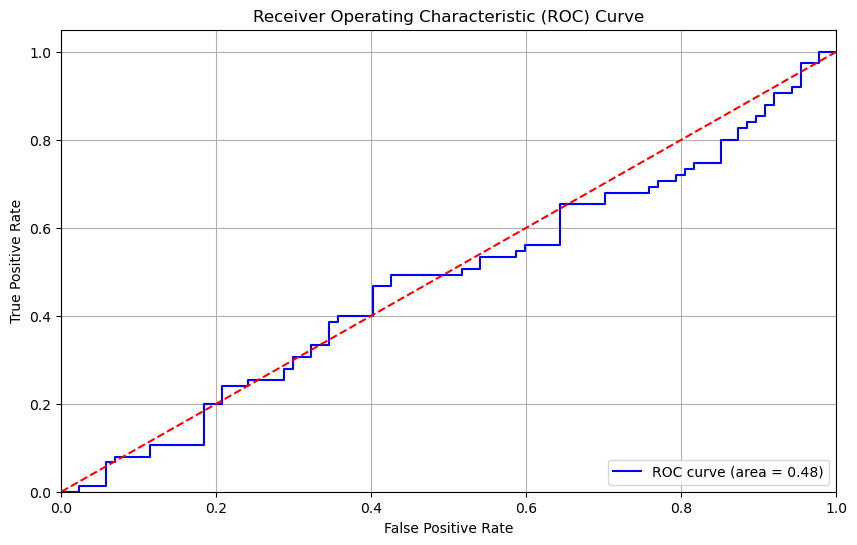

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (1)
y_prob = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_adjusted, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## KNN

In [96]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure the training and testing labels are numpy arrays
y_train_adjusted = np.array(y_train)
y_test_adjusted = np.array(y_test)

# Define the parameter grid for K-Nearest Neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform grid search with cross-validation for KNN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), 
                                param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train_adjusted)

# Get the best model from the grid search
best_knn_model = grid_search_knn.best_estimator_

# Make predictions on the train set
y_pred_train_knn = best_knn_model.predict(X_train)

# Make predictions on the test set
y_pred_test_knn = best_knn_model.predict(X_test)

# Evaluate the performance on the train set
train_accuracy_knn = accuracy_score(y_train_adjusted, y_pred_train_knn)
train_conf_matrix_knn = confusion_matrix(y_train_adjusted, y_pred_train_knn)

# Evaluate the performance on the test set
test_accuracy_knn = accuracy_score(y_test_adjusted, y_pred_test_knn)
test_conf_matrix_knn = confusion_matrix(y_test_adjusted, y_pred_test_knn)
classification_report_result_knn = classification_report(y_test_adjusted, y_pred_test_knn)

# Print the results
print(f"Train Accuracy (KNN): {train_accuracy_knn:.4f}")
print(f"Test Accuracy (KNN): {test_accuracy_knn:.4f}")
print("\nClassification Report (Test Set, KNN):")
print(classification_report_result_knn)

print("\nConfusion Matrix (Train Set, KNN):")
print(train_conf_matrix_knn)

print("\nConfusion Matrix (Test Set, KNN):")
print(test_conf_matrix_knn)


Train Accuracy (KNN): 0.6476
Test Accuracy (KNN): 0.4815

Classification Report (Test Set, KNN):
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        87
           1       0.45      0.57      0.51        75

    accuracy                           0.48       162
   macro avg       0.49      0.49      0.48       162
weighted avg       0.49      0.48      0.48       162


Confusion Matrix (Train Set, KNN):
[[201 113]
 [115 218]]

Confusion Matrix (Test Set, KNN):
[[35 52]
 [32 43]]


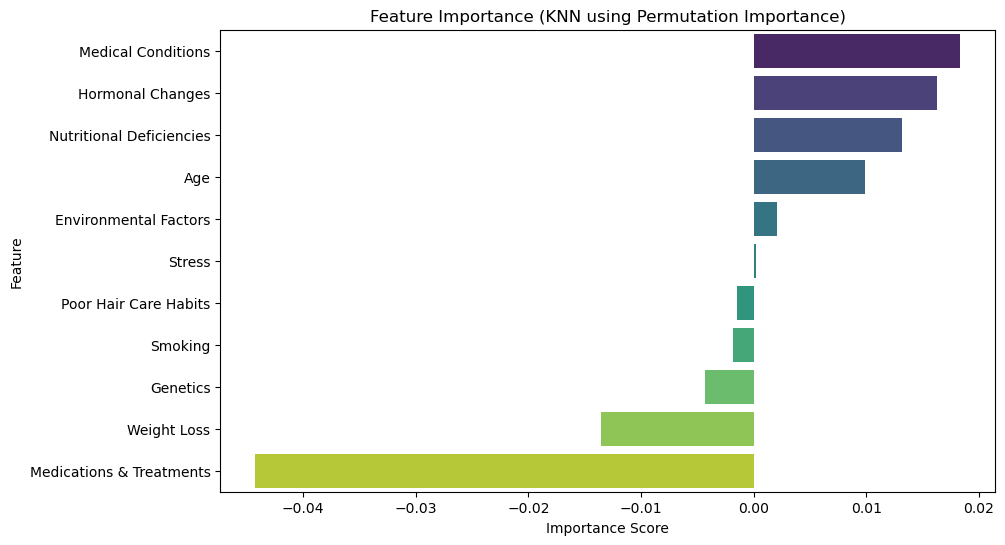

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier

# Assuming you have already fitted best_knn_model on your training data

# Calculate permutation importance
result = permutation_importance(best_knn_model, X_test, y_test_adjusted, n_repeats=30, random_state=42)

# Create a DataFrame with feature names and their importance scores
feature_importance_df_knn = pd.DataFrame({'Feature': X_train.columns, 'Importance': result.importances_mean})

# Sort the DataFrame by importance score in descending order
feature_importance_df_knn = feature_importance_df_knn.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_knn, palette='viridis')
plt.title('Feature Importance (KNN using Permutation Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


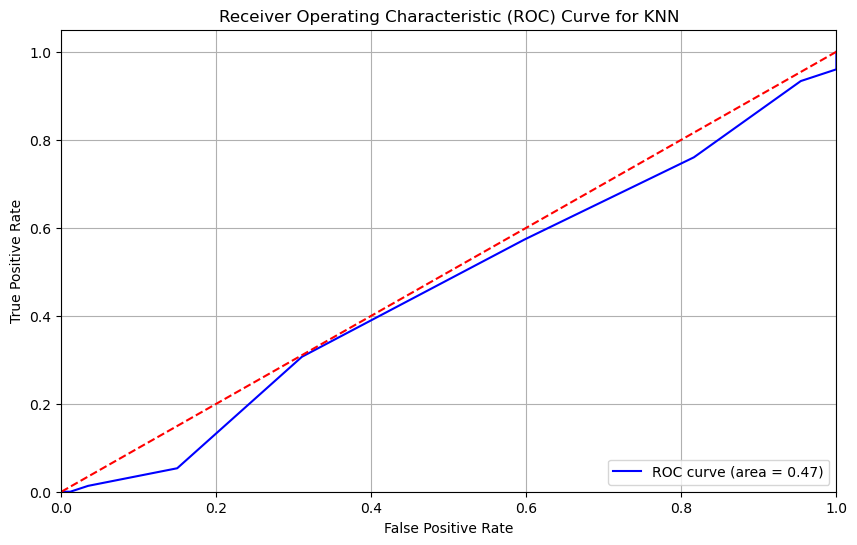

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (1)
y_prob_knn = best_knn_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_adjusted, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc_knn))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Extra Tree

In [100]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure the training and testing labels are numpy arrays
y_train_adjusted = np.array(y_train)
y_test_adjusted = np.array(y_test)

# Define the parameter grid for Extra Trees
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation for Extra Trees
grid_search = GridSearchCV(estimator=ExtraTreesClassifier(), 
                           param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train_adjusted)

# Get the best model from the grid search
best_et_model = grid_search.best_estimator_

# Make predictions on the train set
y_pred_train = best_et_model.predict(X_train)

# Make predictions on the test set
y_pred_test = best_et_model.predict(X_test)

# Evaluate the performance on the train set
train_accuracy = accuracy_score(y_train_adjusted, y_pred_train)
train_conf_matrix = confusion_matrix(y_train_adjusted, y_pred_train)

# Evaluate the performance on the test set
test_accuracy = accuracy_score(y_test_adjusted, y_pred_test)
test_conf_matrix = confusion_matrix(y_test_adjusted, y_pred_test)
classification_report_result = classification_report(y_test_adjusted, y_pred_test)

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report_result)

print("\nConfusion Matrix (Train Set):")
print(train_conf_matrix)

print("\nConfusion Matrix (Test Set):")
print(test_conf_matrix)

Train Accuracy: 0.9413
Test Accuracy: 0.5000

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.55      0.39      0.46        87
           1       0.47      0.63      0.54        75

    accuracy                           0.50       162
   macro avg       0.51      0.51      0.50       162
weighted avg       0.51      0.50      0.49       162


Confusion Matrix (Train Set):
[[288  26]
 [ 12 321]]

Confusion Matrix (Test Set):
[[34 53]
 [28 47]]


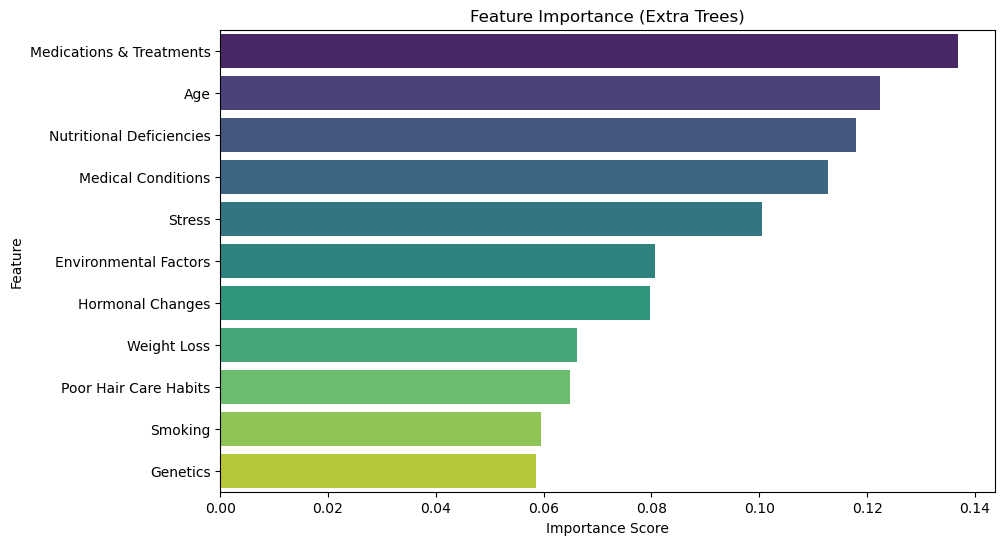

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importance from the best Extra Trees model
feature_importance = best_et_model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance (Extra Trees)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


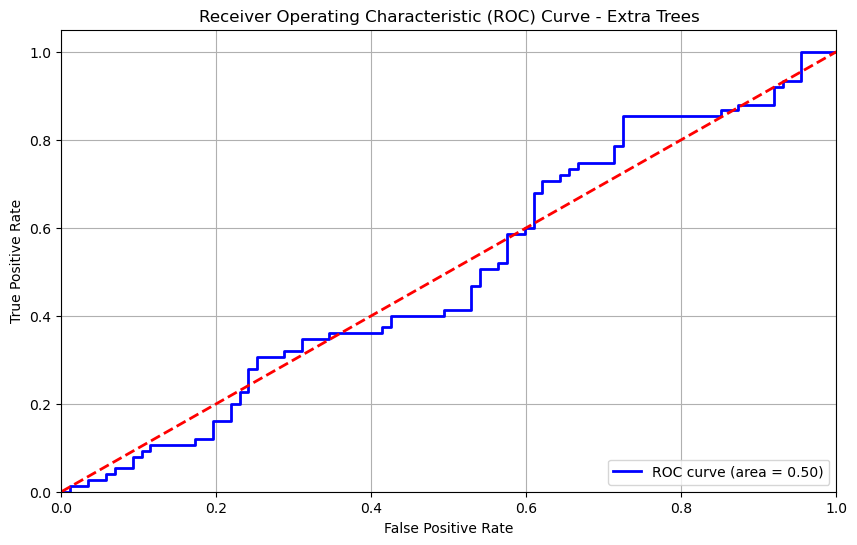

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_pred_proba = best_et_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_adjusted, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Extra Trees')
plt.legend(loc='lower right')
plt.grid()
plt.show()


#### ROC for Train

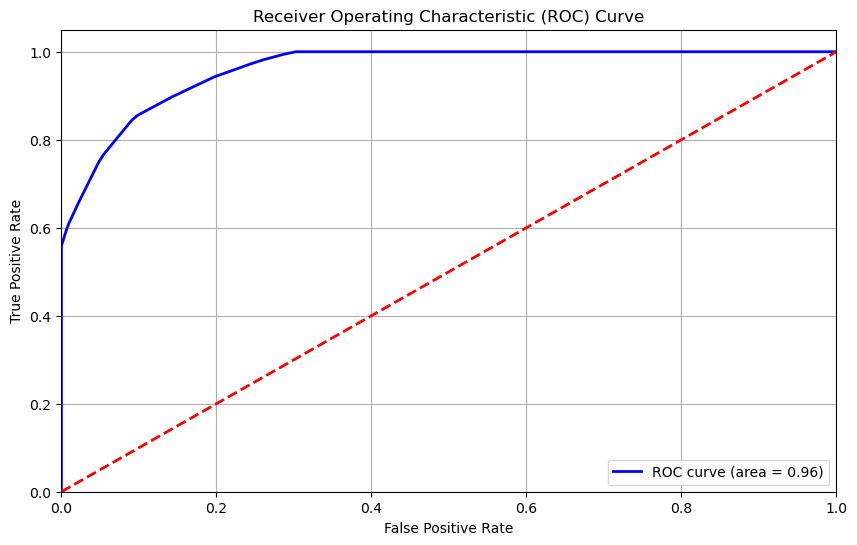

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_pred_proba = best_dt_model.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train_adjusted, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


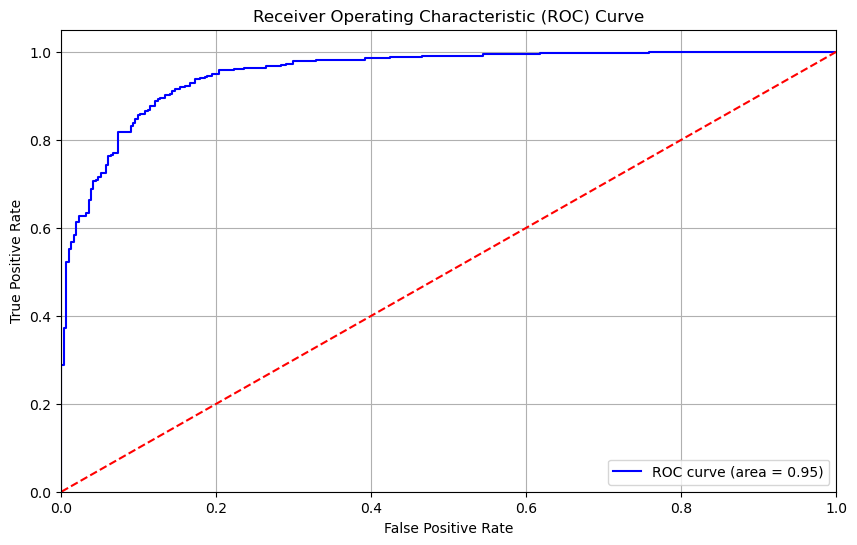

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (1)
y_prob = best_xgb_model.predict_proba(X_train)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train_adjusted, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


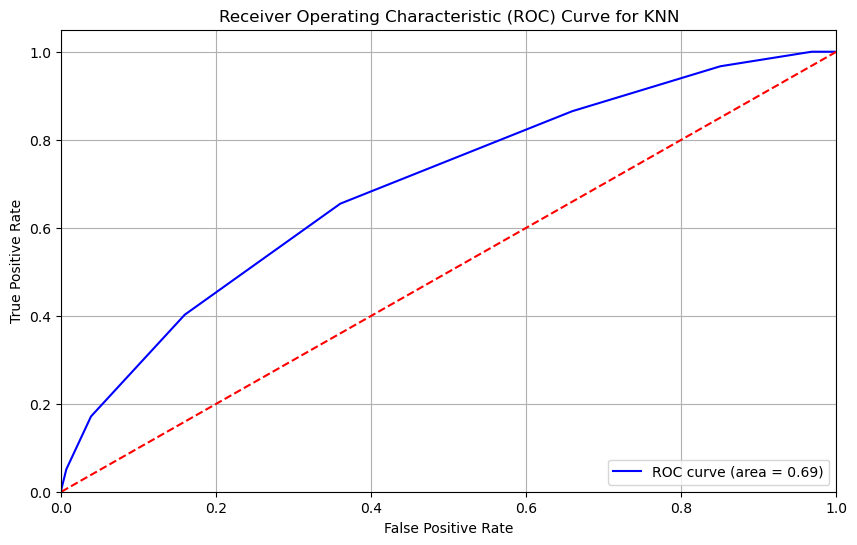

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (1)
y_prob_knn = best_knn_model.predict_proba(X_train)[:, 1]

# Calculate ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train_adjusted, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc_knn))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc='lower right')
plt.grid()
plt.show()

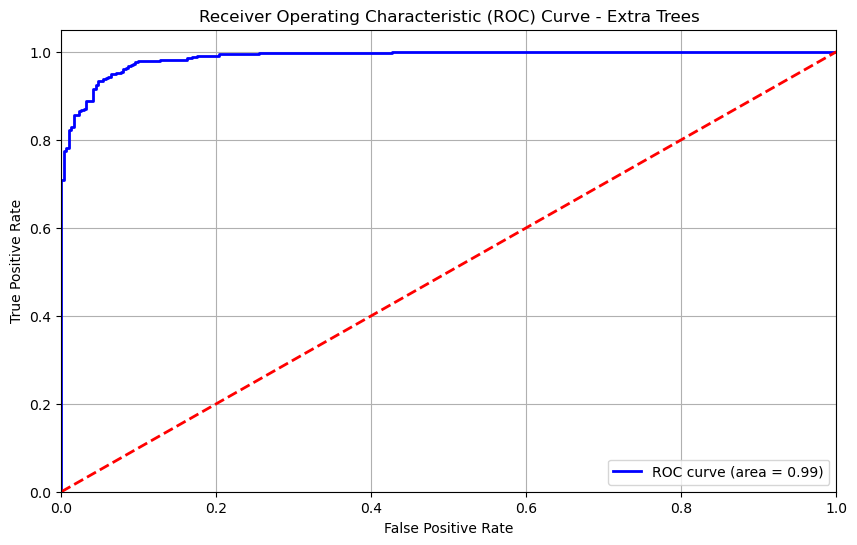

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_pred_proba = best_et_model.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train_adjusted, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Extra Trees')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Stacking Model

In [112]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# Ensure the training and testing labels are numpy arrays
y_train_adjusted = np.array(y_train)
y_test_adjusted = np.array(y_test)

# Define base models for stacking
base_estimators = [
    ('decision_tree', DecisionTreeClassifier(
        criterion=grid_search.best_params_['criterion'],
        max_depth=grid_search.best_params_['max_depth'],
        min_samples_split=grid_search.best_params_['min_samples_split'],
        min_samples_leaf=grid_search.best_params_['min_samples_leaf']
    )),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='linear', probability=True))
]

# Define the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# Train the stacking model
stacking_clf.fit(X_train, y_train_adjusted)

# Make predictions on the train set
y_pred_train_stack = stacking_clf.predict(X_train)

# Make predictions on the test set
y_pred_test_stack = stacking_clf.predict(X_test)

# Evaluate the performance on the train set
train_accuracy_stack = accuracy_score(y_train_adjusted, y_pred_train_stack)
train_conf_matrix_stack = confusion_matrix(y_train_adjusted, y_pred_train_stack)

# Evaluate the performance on the test set
test_accuracy_stack = accuracy_score(y_test_adjusted, y_pred_test_stack)
test_conf_matrix_stack = confusion_matrix(y_test_adjusted, y_pred_test_stack)
classification_report_result_stack = classification_report(y_test_adjusted, y_pred_test_stack)

# Print the results for the stacking model
print(f"Stacking Model - Train Accuracy: {train_accuracy_stack:.4f}")
print(f"Stacking Model - Test Accuracy: {test_accuracy_stack:.4f}")
print("\nStacking Model - Classification Report (Test Set):")
print(classification_report_result_stack)

print("\nStacking Model - Confusion Matrix (Train Set):")
print(train_conf_matrix_stack)

print("\nStacking Model - Confusion Matrix (Test Set):")
print(test_conf_matrix_stack)


Stacking Model - Train Accuracy: 0.7759
Stacking Model - Test Accuracy: 0.4815

Stacking Model - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.54      0.25      0.34        87
           1       0.46      0.75      0.57        75

    accuracy                           0.48       162
   macro avg       0.50      0.50      0.46       162
weighted avg       0.50      0.48      0.45       162


Stacking Model - Confusion Matrix (Train Set):
[[175 139]
 [  6 327]]

Stacking Model - Confusion Matrix (Test Set):
[[22 65]
 [19 56]]


In [113]:
import numpy as np
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define base models for stacking
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gradient_boost', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='linear', probability=True, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42))
]

# Define the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# Train the stacking model
stacking_clf.fit(X_train, y_train)

# Make predictions on the train set
y_pred_train_stack = stacking_clf.predict(X_train)

# Make predictions on the test set
y_pred_test_stack = stacking_clf.predict(X_test)

# Evaluate the performance on the train set
train_accuracy_stack = accuracy_score(y_train, y_pred_train_stack)
train_conf_matrix_stack = confusion_matrix(y_train, y_pred_train_stack)

# Evaluate the performance on the test set
test_accuracy_stack = accuracy_score(y_test, y_pred_test_stack)
test_conf_matrix_stack = confusion_matrix(y_test, y_pred_test_stack)
classification_report_result_stack = classification_report(y_test, y_pred_test_stack)

# Print the results for the stacking model
print(f"Stacking Model - Train Accuracy: {train_accuracy_stack:.4f}")
print(f"Stacking Model - Test Accuracy: {test_accuracy_stack:.4f}")
print("\nStacking Model - Classification Report (Test Set):")
print(classification_report_result_stack)

print("\nStacking Model - Confusion Matrix (Train Set):")
print(train_conf_matrix_stack)

print("\nStacking Model - Confusion Matrix (Test Set):")
print(test_conf_matrix_stack)

Stacking Model - Train Accuracy: 0.9784
Stacking Model - Test Accuracy: 0.4938

Stacking Model - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.55      0.30      0.39        87
           1       0.47      0.72      0.57        75

    accuracy                           0.49       162
   macro avg       0.51      0.51      0.48       162
weighted avg       0.51      0.49      0.47       162


Stacking Model - Confusion Matrix (Train Set):
[[300  14]
 [  0 333]]

Stacking Model - Confusion Matrix (Test Set):
[[26 61]
 [21 54]]


In [114]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the structure of the ANN model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))

# Second hidden layer
model.add(Dense(units=32, activation='relu'))

# Output layer (assuming binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions on the test set
y_pred_test = (model.predict(X_test) > 0.5).astype("int32")
y_pred_train = (model.predict(X_train) > 0.5).astype("int32")

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_conf_matrix = confusion_matrix(y_train, y_pred_train)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

classification_report_result = classification_report(y_test, y_pred_test)

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report_result)

print("\nConfusion Matrix (Train Set):")
print(train_conf_matrix)

print("\nConfusion Matrix (Test Set):")
print(test_conf_matrix)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4882 - loss: 0.8303 - val_accuracy: 0.5185 - val_loss: 0.7151
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5174 - loss: 0.7076 - val_accuracy: 0.5185 - val_loss: 0.7076
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5367 - loss: 0.6999 - val_accuracy: 0.4506 - val_loss: 0.7136
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5272 - loss: 0.6905 - val_accuracy: 0.4259 - val_loss: 0.7279
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5216 - loss: 0.6937 - val_accuracy: 0.4630 - val_loss: 0.8234
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4857 - loss: 0.7294 - val_accuracy: 0.4815 - val_loss: 0.7104
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5670 - loss: 0.6852 - val_accuracy: 0.5370 - val_loss: 0.7036
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5952 - loss: 0.6740 - val_accuracy: 0.5494 - val_loss